In [32]:
#Ignore warnings
import warnings
warnings.filterwarnings("ignore")

#imports for user defined functions
from env import host, user, password, get_db_url

# Imports for arithmetic calculations and data frame manipulation
import math
import numpy as np
import pandas as pd

#Imports for statistical analysis
from scipy import stats
import statistics

#imports for splitting data and imputing
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

#Imports for creating visualizations
import matplotlib.pyplot as plt 
import seaborn as sns


## Planning

What are my goals/deliverables?
- Construct an ML Regression model that predict propery tax assessed values ('taxvaluedollarcnt') of Single Family Properties using attributes of the properties.
- Find the key drivers of property value for single family properties. Some questions that come to mind are: Why do some properties have a much higher value than others when they are located so close to each other? Why are some properties valued so differently from others when they have nearly the same physical attributes but only differ in location? Is having 1 bathroom worse than having 2 bedrooms?
- Deliver a report that the data science team can read through and replicate, understand what steps were taken, why and what the outcome was.
- Make recommendations on what works or doesn't work in prediction these homes' values.

Planning Steps:
- Create a README.md to document my process, my key findings and provide instructions on how to replicate the project.
- Acquire the zillow data from the MySQL database and then create and store functions to replicate this process in a wrangle.py file.
- Complete initial summary of data to see what I am working with: .info(), .describe(), .value_counts()
- Decided which columns are useful and relevant to move forward with. 
- Conduct intial univariate exploration, plot distributions of relevant variables, and make decisions on which variables I will move forward with for further exploration and eventually modeling.
    - I will begin first iteration by creating a dataframe that only contains the required variables to reach the Minimum Viable Product: square feet, number of bedrooms and bathrooms, and the target -- taxvaluedollarcnt.
- Conduct further cleaning and preparation of data: 
    - Dropping outliers if necessary
    - Removing or imputing nulls if necessary
    - Renaming columns
    - Changing data types
- Create a seperate data frame that converts fips to corresponding county for exploration. 
- Form initial hypotheses and questions to investigate
- Split data and begin further exploration on the train data.
    - Evaluate hypotheses using statistical tests
    - Create visualizations of variable interactions
    - Decide which variables are key drivers to be used in modeling
- Split data into X and y subgroup to be used in modeling
- Set a baseline using the target mean or median. 
- Conduct preprocessing including one hot encoding and creating dummy variables where necessary before modeling.
- Scale data if necesary.
- Create and fit models on train data set and then evaluate on the validate data set. 
- Choose my best model and evaluate it on the test data set. 
- Document my findings and conclusions in a Final Report Notebook.

## Data Acquisition


**Project Guidance:**
- You will need to use the properties_2017, predictions_2017, and propertylandusetype tables.
- You are asked to use properties that had a transaction in 2017! You must figure out how to determine which properties those are and filter your data IN SQL before bringing it in to your python environment! 
- For the first iteration of your model, use only square feet of the home, number of bedrooms, and number of bathrooms to estimate the property's assessed value, taxvaluedollarcnt. You can expand this to other fields after you have completed an mvp (minimally viable product).
- Be sure and remove the fields that leak information about taxvaluedollarcnt. These are fields we would not know until we knew the assessed value, so using them would be "cheating". These fields are landtaxvaluedollarcnt, structuretaxvaluedollarcnt, and taxamount.

In [33]:
# SQL query to acquire data

query = '''
SELECT * FROM properties_2017 
LEFT JOIN predictions_2017 USING (parcelid) 
LEFT JOIN propertylandusetype USING (propertylandusetypeid)
WHERE propertylandusedesc IN ('Single Family Residential', 'Inferred Single Family Residential') 
AND YEAR(transactiondate) = 2017;
'''

zillow = pd.read_sql(query, get_db_url('zillow'))
zillow.head()

,propertylandusetypeid,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id,logerror,transactiondate,propertylandusedesc
0,261.0,12612840,1514581,NaN,NaN,NaN,2.0,3.0,None,6.0,...,2016.0,33940.0,1104.70,None,NaN,6.037670e+13,889,0.079772,2017-01-05,Single Family Residential
1,261.0,12611007,216904,NaN,NaN,NaN,2.0,3.0,None,6.0,...,2016.0,110958.0,2506.91,None,NaN,6.037670e+13,888,0.100001,2017-01-05,Single Family Residential
2,261.0,12023386,304078,NaN,NaN,NaN,2.0,2.0,None,8.0,...,2016.0,34974.0,1229.29,None,NaN,6.037194e+13,886,-0.006511,2017-01-05,Single Family Residential
3,261.0,11647399,1943418,NaN,NaN,NaN,4.0,3.0,None,9.0,...,2016.0,1350336.0,20436.93,None,NaN,6.037265e+13,883,0.006355,2017-01-05,Single Family Residential
4,261.0,10780171,90918,1.0,NaN,NaN,3.0,3.0,None,8.0,...,2016.0,57957.0,2851.71,None,NaN,6.037133e+13,882,-0.059383,2017-01-05,Single Family Residential


In [34]:
# Look at and summarize data
zillow.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52441 entries, 0 to 52440
Data columns (total 63 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   propertylandusetypeid         52441 non-null  float64
 1   parcelid                      52441 non-null  int64  
 2   id                            52441 non-null  int64  
 3   airconditioningtypeid         13638 non-null  float64
 4   architecturalstyletypeid      70 non-null     float64
 5   basementsqft                  47 non-null     float64
 6   bathroomcnt                   52441 non-null  float64
 7   bedroomcnt                    52441 non-null  float64
 8   buildingclasstypeid           0 non-null      object 
 9   buildingqualitytypeid         33740 non-null  float64
 10  calculatedbathnbr             52304 non-null  float64
 11  decktypeid                    389 non-null    float64
 12  finishedfloor1squarefeet      4381 non-null   float64
 13  c

In [35]:
zillow.describe().T

,count,mean,std,min,25%,50%,75%,max
propertylandusetypeid,52441.0,2.610000e+02,0.000000e+00,2.610000e+02,2.610000e+02,2.610000e+02,2.610000e+02,2.610000e+02
parcelid,52441.0,1.299912e+07,3.411444e+06,1.071186e+07,1.151022e+07,1.257764e+07,1.412953e+07,1.676878e+08
id,52441.0,1.497270e+06,8.594393e+05,3.490000e+02,7.579550e+05,1.500810e+06,2.241534e+06,2.982270e+06
airconditioningtypeid,13638.0,2.438041e+00,3.846176e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.300000e+01
architecturalstyletypeid,70.0,7.100000e+00,2.665670e+00,2.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00,2.100000e+01
basementsqft,47.0,6.789787e+02,7.118252e+02,3.800000e+01,2.635000e+02,5.120000e+02,8.095000e+02,3.560000e+03
bathroomcnt,52441.0,2.299403e+00,1.022772e+00,0.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01
bedroomcnt,52441.0,3.300681e+00,9.490939e-01,0.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,1.400000e+01
buildingqualitytypeid,33740.0,6.264167e+00,1.716162e+00,1.000000e+00,5.000000e+00,6.000000e+00,8.000000e+00,1.200000e+01
calculatedbathnbr,52304.0,2.304738e+00,1.017966e+00,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01


Takeaways:
- There are several id colums that are limited and don't provide useful information so they will need to be removed.
- Multiple other columns have very limited data or none at all. Since there is no easy method to impute or fill these values they will need to be remove including: basementsqft, buildingclasstypeid, finishedsquarefeet13, finishedsquarefeet15,finishedsquarefeet6, etc.
- It will be easier to simply select the colums that I actually want so I will create a new SQL query that does that before caching it to a csv.

In [36]:
# New SQL query to acquire desired data

query = '''
SELECT transactiondate, taxvaluedollarcnt, taxamount, roomcnt, bathroomcnt, bedroomcnt, garagecarcnt, numberofstories, lotsizesquarefeet, garagetotalsqft, calculatedfinishedsquarefeet, yearbuilt, fips, regionidcounty, regionidzip, propertycountylandusecode 
FROM properties_2017 
LEFT JOIN predictions_2017 USING (parcelid) 
LEFT JOIN propertylandusetype USING (propertylandusetypeid)
WHERE propertylandusedesc IN ('Single Family Residential', 'Inferred Single Family Residential') 
AND YEAR(transactiondate) = 2017;
'''

zillow = pd.read_sql(query, get_db_url('zillow'))
zillow.head()

,transactiondate,taxvaluedollarcnt,taxamount,roomcnt,bathroomcnt,bedroomcnt,garagecarcnt,numberofstories,lotsizesquarefeet,garagetotalsqft,calculatedfinishedsquarefeet,yearbuilt,fips,regionidcounty,regionidzip,propertycountylandusecode
0,2017-01-01,1023282.0,11013.72,0.0,3.5,4.0,2.0,NaN,4506.0,633.0,3100.0,1998.0,6059.0,1286.0,96978.0,122
1,2017-01-01,464000.0,5672.48,5.0,1.0,2.0,1.0,1.0,12647.0,0.0,1465.0,1967.0,6111.0,2061.0,97099.0,1110
2,2017-01-01,564778.0,6488.30,6.0,2.0,3.0,2.0,1.0,8432.0,440.0,1243.0,1962.0,6059.0,1286.0,97078.0,122
3,2017-01-01,145143.0,1777.51,0.0,3.0,4.0,NaN,NaN,13038.0,NaN,2376.0,1970.0,6037.0,3101.0,96330.0,0101
4,2017-01-01,773303.0,9516.26,0.0,3.0,4.0,NaN,NaN,63000.0,NaN,2962.0,1950.0,6037.0,3101.0,96293.0,0101


In [37]:
# Look at and summarize data
zillow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52441 entries, 0 to 52440
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   transactiondate               52441 non-null  object 
 1   taxvaluedollarcnt             52440 non-null  float64
 2   taxamount                     52437 non-null  float64
 3   roomcnt                       52441 non-null  float64
 4   bathroomcnt                   52441 non-null  float64
 5   bedroomcnt                    52441 non-null  float64
 6   garagecarcnt                  18015 non-null  float64
 7   numberofstories               14561 non-null  float64
 8   lotsizesquarefeet             52072 non-null  float64
 9   garagetotalsqft               18015 non-null  float64
 10  calculatedfinishedsquarefeet  52359 non-null  float64
 11  yearbuilt                     52325 non-null  float64
 12  fips                          52441 non-null  float64
 13  r

In [38]:
zillow.describe().T

,count,mean,std,min,25%,50%,75%,max
taxvaluedollarcnt,52440.0,529688.163921,751894.553363,1000.00,193747.50,373612.00,619301.25,49061236.0
taxamount,52437.0,6453.511209,8755.568452,49.18,2656.22,4647.74,7377.50,586639.3
roomcnt,52441.0,1.893709,3.146437,0.00,0.00,0.00,5.00,15.0
bathroomcnt,52441.0,2.299403,1.022772,0.00,2.00,2.00,3.00,18.0
bedroomcnt,52441.0,3.300681,0.949094,0.00,3.00,3.00,4.00,14.0
garagecarcnt,18015.0,1.948987,0.549944,0.00,2.00,2.00,2.00,14.0
numberofstories,14561.0,1.413914,0.540677,1.00,1.00,1.00,2.00,6.0
lotsizesquarefeet,52072.0,11339.624078,86747.634061,236.00,5583.00,6840.50,8798.25,6971010.0
garagetotalsqft,18015.0,495.875715,157.044712,0.00,426.00,462.00,567.00,4251.0
calculatedfinishedsquarefeet,52359.0,1922.890754,1004.365838,128.00,1268.00,1659.00,2306.00,21929.0


In [39]:
# Store desired data as csv
zillow.to_csv('zillow_project', index =False)
# Acquire data from csv for faster computations
zillow = pd.read_csv('zillow_project')
zillow.head()

,transactiondate,taxvaluedollarcnt,taxamount,roomcnt,bathroomcnt,bedroomcnt,garagecarcnt,numberofstories,lotsizesquarefeet,garagetotalsqft,calculatedfinishedsquarefeet,yearbuilt,fips,regionidcounty,regionidzip,propertycountylandusecode
0,2017-01-01,1023282.0,11013.72,0.0,3.5,4.0,2.0,NaN,4506.0,633.0,3100.0,1998.0,6059.0,1286.0,96978.0,122
1,2017-01-01,464000.0,5672.48,5.0,1.0,2.0,1.0,1.0,12647.0,0.0,1465.0,1967.0,6111.0,2061.0,97099.0,1110
2,2017-01-01,564778.0,6488.30,6.0,2.0,3.0,2.0,1.0,8432.0,440.0,1243.0,1962.0,6059.0,1286.0,97078.0,122
3,2017-01-01,145143.0,1777.51,0.0,3.0,4.0,NaN,NaN,13038.0,NaN,2376.0,1970.0,6037.0,3101.0,96330.0,0101
4,2017-01-01,773303.0,9516.26,0.0,3.0,4.0,NaN,NaN,63000.0,NaN,2962.0,1950.0,6037.0,3101.0,96293.0,0101


## Cleaning/Prepping Data

*According to project guidelines the first iteration to attain the MVP will only use square feet of home, number of bedrooms, and number of bathrooms to estimate property's assesed value (taxvaluedollarcnt). Asside from the main goal of predicting propety value, another business goal is to determine the state and county of each property for tax assessment purposes. I will create a data frame that only includes the necessary fields.*

In [40]:
df = zillow[['bedroomcnt', 'bathroomcnt', 'yearbuilt', 'calculatedfinishedsquarefeet', 'fips', 'taxamount', 'taxvaluedollarcnt']]
df.head()

,bedroomcnt,bathroomcnt,yearbuilt,calculatedfinishedsquarefeet,fips,taxamount,taxvaluedollarcnt
0,4.0,3.5,1998.0,3100.0,6059.0,11013.72,1023282.0
1,2.0,1.0,1967.0,1465.0,6111.0,5672.48,464000.0
2,3.0,2.0,1962.0,1243.0,6059.0,6488.30,564778.0
3,4.0,3.0,1970.0,2376.0,6037.0,1777.51,145143.0
4,4.0,3.0,1950.0,2962.0,6037.0,9516.26,773303.0


In [41]:
# rename columns for clarity and readability
df = df.rename(columns={'bedroomcnt': 'beds', 'bathroomcnt':'baths', 'yearbuilt':'year_built', 'calculatedfinishedsquarefeet':'square_feet', 'taxvaluedollarcnt':'assessed_value', 'taxamount':'tax_amount'})
df.head()

,beds,baths,year_built,square_feet,fips,tax_amount,assessed_value
0,4.0,3.5,1998.0,3100.0,6059.0,11013.72,1023282.0
1,2.0,1.0,1967.0,1465.0,6111.0,5672.48,464000.0
2,3.0,2.0,1962.0,1243.0,6059.0,6488.30,564778.0
3,4.0,3.0,1970.0,2376.0,6037.0,1777.51,145143.0
4,4.0,3.0,1950.0,2962.0,6037.0,9516.26,773303.0


In [42]:
# Re-check and summarize data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52441 entries, 0 to 52440
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   beds            52441 non-null  float64
 1   baths           52441 non-null  float64
 2   year_built      52325 non-null  float64
 3   square_feet     52359 non-null  float64
 4   fips            52441 non-null  float64
 5   tax_amount      52437 non-null  float64
 6   assessed_value  52440 non-null  float64
dtypes: float64(7)
memory usage: 2.8 MB


In [43]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
beds,52441.0,3.300681,0.949094,0.00,3.00,3.00,4.00,14.0
baths,52441.0,2.299403,1.022772,0.00,2.00,2.00,3.00,18.0
year_built,52325.0,1963.393884,23.133571,1878.00,1950.00,1961.00,1979.00,2016.0
square_feet,52359.0,1922.890754,1004.365838,128.00,1268.00,1659.00,2306.00,21929.0
fips,52441.0,6049.132149,21.029067,6037.00,6037.00,6037.00,6059.00,6111.0
tax_amount,52437.0,6453.511209,8755.568452,49.18,2656.22,4647.74,7377.50,586639.3
assessed_value,52440.0,529688.163921,751894.553363,1000.00,193747.50,373612.00,619301.25,49061236.0


In [44]:
# Calculate amount of nulls
df.isna().sum()

beds                0
baths               0
year_built        116
square_feet        82
fips                0
tax_amount          4
assessed_value      1
dtype: int64

*Due to low amount of nulls I will impute missing square feet using the mean or median value and drop the 5 rows that are missing tax_amount and assessed_value. I will also impute for the missing year_built if necessary. I'll first do some quick univariate visualizations to decide on my approach.*

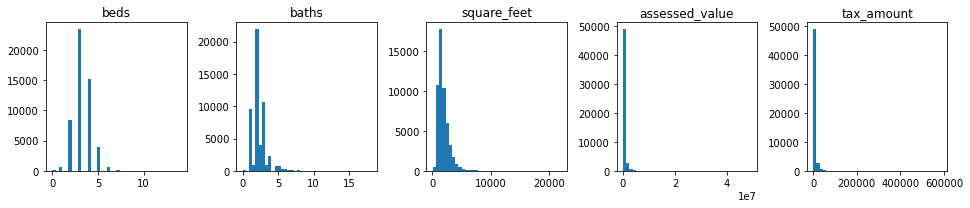

In [45]:
plt.figure(figsize=(16, 3))

# List of columns
cols = ['beds', 'baths', 'square_feet', 'assessed_value', 'tax_amount']

for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1, 6, plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    df[col].hist(bins=40)

    # Hide gridlines.
    plt.grid(False)
    
    #turn off scientific notation
    plt.ticklabel_format(useOffset=False)
    
    #get rid of overlapping plots
    plt.tight_layout()
    
plt.show()

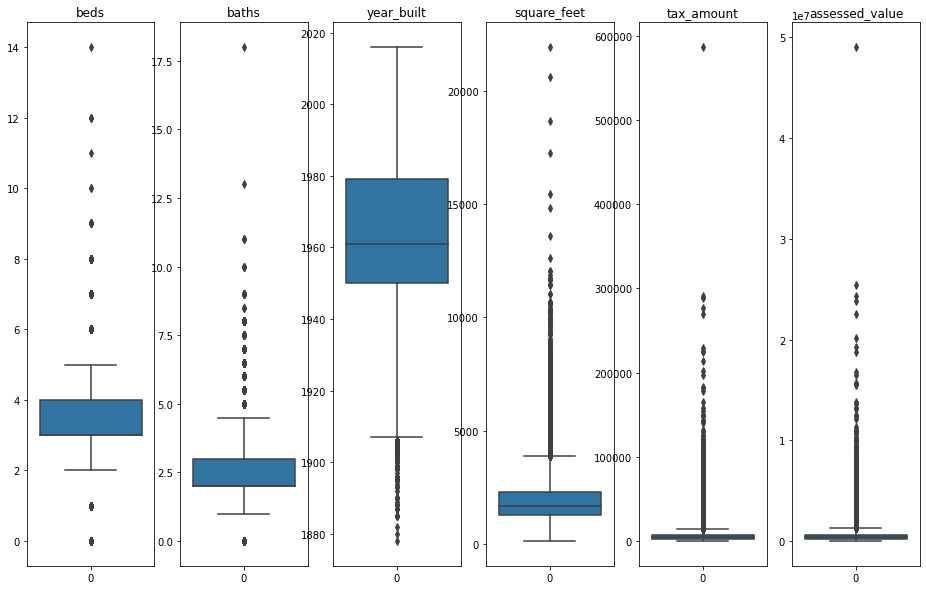

In [46]:
# List of columns
cols = [col for col in df.columns if col not in ['fips']]
plt.figure(figsize=(16, 10))
for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display boxplot for column.
    sns.boxplot(data=df[col])

    # Hide gridlines.
    plt.grid(False)

plt.show()

Takeaways:
- There are outliers causing significant skewing of each of my variables. I will need to drop outliers to get a more accurate view of the distributions. (For purpose of this course dropping outliers before splitting data is allowed but I understand that there are good reasons to only drop outliers on train data once the data is split.) 
- Median square feet will be less skewed than mean square feet so I will use this strategy for imputing data if still necessary after dropping outliers.

### Dropping outliers and re-assessing distributions

In [47]:
# Create function to remove outliers

def remove_outliers(df, k, col_list):
    ''' remove outliers from a list of columns in a dataframe 
        and return that dataframe
    '''
    
    for col in col_list:

        q1, q3 = df[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # return dataframe without outliers
        
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
        
    return df

In [48]:
# Remove outliers from our data
df = remove_outliers(df, 1.5, ['beds', 'baths', 'square_feet', 'assessed_value', 'tax_amount'])
df.head()

,beds,baths,year_built,square_feet,fips,tax_amount,assessed_value
0,4.0,3.5,1998.0,3100.0,6059.0,11013.72,1023282.0
1,2.0,1.0,1967.0,1465.0,6111.0,5672.48,464000.0
2,3.0,2.0,1962.0,1243.0,6059.0,6488.30,564778.0
3,4.0,3.0,1970.0,2376.0,6037.0,1777.51,145143.0
4,4.0,3.0,1950.0,2962.0,6037.0,9516.26,773303.0


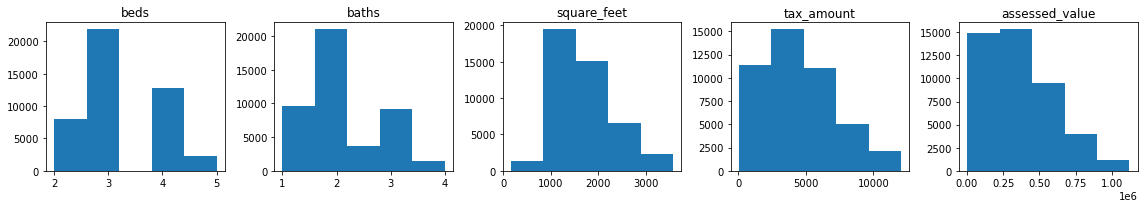

In [49]:
plt.figure(figsize=(16, 3))

# List of columns
cols = [col for col in df.columns if col not in ['fips', 'year_built']]

for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    df[col].hist(bins=5)

    # Hide gridlines.
    plt.grid(False)
    
    # turn off scientific notation
    plt.ticklabel_format(useOffset=False)
    
    # mitigate overlap
    plt.tight_layout()
    
plt.show()

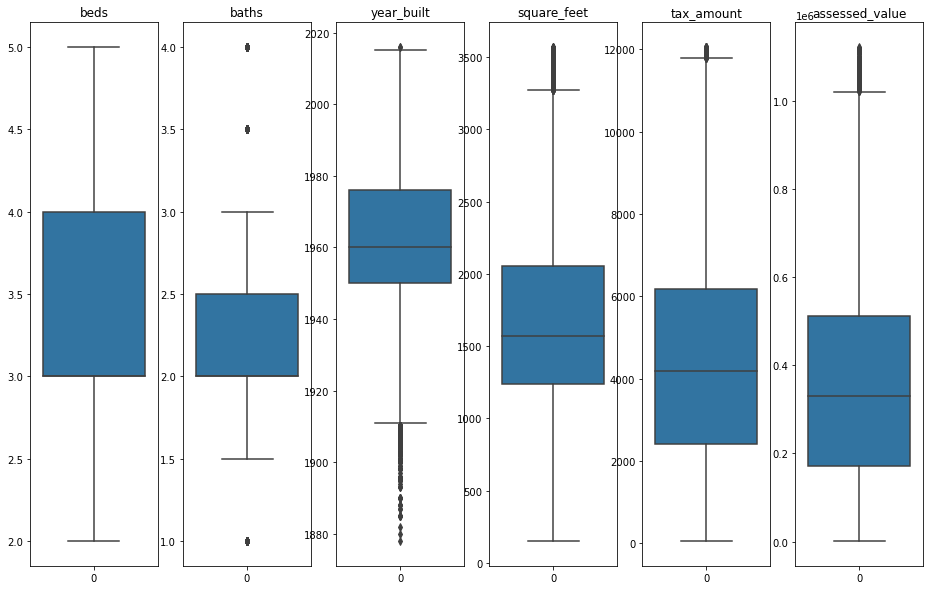

In [50]:
# List of columns
cols = [col for col in df.columns if col not in ['fips']]
plt.figure(figsize=(16, 10))
for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display boxplot for column.
    sns.boxplot(data=df[col])

    # Hide gridlines.
    plt.grid(False)

plt.show()

Takeaways:
- Beds and baths don't have a normal distribution.
- There is some remaining skewdness in my variables but it is at an acceptable level to move forward.

In [51]:
# Re-assess null values after dropping outliers
# Calculate amount of nulls
df.isna().sum()

beds               0
baths              0
year_built        20
square_feet        0
fips               0
tax_amount         0
assessed_value     0
dtype: int64

*Dropping outliers removed most of my null values, I will only impute for the 20 year built based on the median. However, this imputation will need to occur after data splitting.*

### Changing data types

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44884 entries, 0 to 52440
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   beds            44884 non-null  float64
 1   baths           44884 non-null  float64
 2   year_built      44864 non-null  float64
 3   square_feet     44884 non-null  float64
 4   fips            44884 non-null  float64
 5   tax_amount      44884 non-null  float64
 6   assessed_value  44884 non-null  float64
dtypes: float64(7)
memory usage: 3.7 MB


In [53]:
# Converting floats to ints where appropriate
df.beds = df.beds.astype(int)
df.square_feet = df.square_feet.astype(int)
df.assessed_value = df.assessed_value.astype(int)

# Converting fips and year built into a string value as they  categorical data
## Must first be converted to int to remove the decimal and zero
df.fips = df.fips.astype(int)
df.fips = df.fips.astype(str)


## Check converted data frame
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44884 entries, 0 to 52440
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   beds            44884 non-null  int64  
 1   baths           44884 non-null  float64
 2   year_built      44864 non-null  float64
 3   square_feet     44884 non-null  int64  
 4   fips            44884 non-null  object 
 5   tax_amount      44884 non-null  float64
 6   assessed_value  44884 non-null  int64  
dtypes: float64(3), int64(3), object(1)
memory usage: 3.7+ MB


## Acquiring state and county associated with FIPS

In [54]:
df.fips.value_counts()

6037    29206
6059    11837
6111     3841
Name: fips, dtype: int64

I found that:
- 06037 = Los Angeles County, CA
- 06059 = Orange County, CA
- 0611 = Ventura County, CA

*Utilized data from: https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697*

*For data clarity in the exploration process, I will make convert the fips columns to a county column with the corresponding values.*

In [55]:
# convert the fips values to corresponding counties
df['fips'] = df.fips.map({'6037': 'Los Angeles', '6059':'Orange', '6111':'Ventura'})
df.head()

,beds,baths,year_built,square_feet,fips,tax_amount,assessed_value
0,4,3.5,1998.0,3100,Orange,11013.72,1023282
1,2,1.0,1967.0,1465,Ventura,5672.48,464000
2,3,2.0,1962.0,1243,Orange,6488.30,564778
3,4,3.0,1970.0,2376,Los Angeles,1777.51,145143
4,4,3.0,1950.0,2962,Los Angeles,9516.26,773303


In [56]:
# rename fips column to county
df.rename(columns={'fips':'county'}, inplace=True)
df.head()

,beds,baths,year_built,square_feet,county,tax_amount,assessed_value
0,4,3.5,1998.0,3100,Orange,11013.72,1023282
1,2,1.0,1967.0,1465,Ventura,5672.48,464000
2,3,2.0,1962.0,1243,Orange,6488.30,564778
3,4,3.0,1970.0,2376,Los Angeles,1777.51,145143
4,4,3.0,1950.0,2962,Los Angeles,9516.26,773303


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44884 entries, 0 to 52440
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   beds            44884 non-null  int64  
 1   baths           44884 non-null  float64
 2   year_built      44864 non-null  float64
 3   square_feet     44884 non-null  int64  
 4   county          44884 non-null  object 
 5   tax_amount      44884 non-null  float64
 6   assessed_value  44884 non-null  int64  
dtypes: float64(3), int64(3), object(1)
memory usage: 3.7+ MB


## Plot distribution of counties

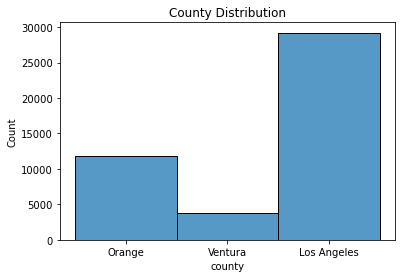

In [58]:
sns.histplot(x = 'county', data=df)
plt.title('County Distribution')
plt.show()

Takeways:
- Most homes are in Los Angeles county. 
- I may want to create a variable that calculates the tax rates of each county to see how these compare and how it can be used to predict assessed value. For the sake of time in acquiring an MVP I will move on for now. 

## Split Data

In [59]:
# train/validate/test split
train_validate, test = train_test_split(df, test_size=.2, random_state=123)
train, validate = train_test_split(train_validate, test_size=.3, random_state=123)

train.shape, validate.shape, test.shape

((25134, 7), (10773, 7), (8977, 7))

In [60]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25134 entries, 14961 to 47917
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   beds            25134 non-null  int64  
 1   baths           25134 non-null  float64
 2   year_built      25123 non-null  float64
 3   square_feet     25134 non-null  int64  
 4   county          25134 non-null  object 
 5   tax_amount      25134 non-null  float64
 6   assessed_value  25134 non-null  int64  
dtypes: float64(3), int64(3), object(1)
memory usage: 1.5+ MB


## Test my wrangle_zillow() function

In [61]:
import wrangle as wr

In [62]:
train, validate, test = wr.wrangle_zillow_mvp()
train.shape, validate.shape, test.shape

Using cached csv...


((25550, 6), (10950, 6), (9126, 6))

In [63]:
train.head()

,bedrooms,bathrooms,year_built,square_feet,county,assessed_value
17219,4,2.0,1979.0,1909,Ventura,296809
36164,3,3.0,1999.0,3159,Ventura,938664
16548,4,3.0,1956.0,2825,Ventura,766513
29763,3,2.0,1947.0,1350,Los Angeles,464414
22852,2,1.0,1947.0,740,Orange,117601


In [64]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25550 entries, 17219 to 9405
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bedrooms        25550 non-null  int64  
 1   bathrooms       25550 non-null  float64
 2   year_built      25550 non-null  float64
 3   square_feet     25550 non-null  int64  
 4   county          25550 non-null  object 
 5   assessed_value  25550 non-null  int64  
dtypes: float64(2), int64(3), object(1)
memory usage: 1.4+ MB
